<a href="https://colab.research.google.com/github/joaochenriques/WE_LAB_2023/blob/main/YB_ExpAnalysis_V01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Select test case

In [1]:
# CASE_prefix = 'YB2m'
CASE_prefix = 'KB4m'

In [2]:
import matplotlib.pyplot as mpl
import h5py
import numpy as np
import pandas as pd
import scipy.signal
from dataclasses import dataclass, field
import pathlib, subprocess, os

In [3]:
def cmdcall( cmd ):
    output = subprocess.getoutput( cmd )
    print(output)

In [4]:
try:
  import xlsxwriter
except ModuleNotFoundError:
  cmdcall( 'pip install xlsxwriter' )
  import xlsxwriter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.8/152.8 KB 3.6 MB/s eta 0:00:00


In [5]:
if not pathlib.Path("mpl_utils.py").exists():
    cmdcall( "curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py" ) 

import mpl_utils as mut
mut.config_plots()

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

mpl.rcParams["figure.figsize"] = (6,4.5)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  3921  100  3921    0     0  19033      0 --:--:-- --:--:-- --:--:-- 18942
100  3921  100  3921    0     0  19033      0 --:--:-- --:--:-- --:--:-- 18942


In [6]:
if not pathlib.Path( "%s_Tests_V6.h5" % CASE_prefix ).exists():
    cmdcall( "curl -O https://raw.githubusercontent.com/joaochenriques/WE_LAB_2023/main/%s_Tests_V6.zip" % CASE_prefix )
    cmdcall( "unzip %s_Tests_V6.zip" % CASE_prefix )

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2189k  100 2189k    0     0  4739k      0 --:--:-- --:--:-- --:--:-- 4739k
Archive:  KB4m_Tests_V6.zip
  inflating: KB4m_Tests_V6.h5        


In [7]:
if not pathlib.Path( "%s_Cameras_XLS_V6.zip" % CASE_prefix ).exists():
    cmdcall( "curl -O https://raw.githubusercontent.com/joaochenriques/WE_LAB_2023/main/%s_Cameras_XLS_V6.zip" % CASE_prefix )
    cmdcall( "unzip %s_Cameras_XLS_V6.zip" % CASE_prefix )

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0 11.7M    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 11.7M  100 11.7M    0     0  16.1M      0 --:--:-- --:--:-- --:--:-- 16.1M
Archive:  KB4m_Cameras_XLS_V6.zip
  inflating: KB4m_H0.04m_f0.64Hz.xlsx  
  inflating: KB4m_H0.04m_f0.70Hz.xlsx  
 extracting: KB4m_H0.04m_f0.74Hz..xlsx  
  inflating: KB4m_H0.04m_f0.74Hz.xlsx  
  inflating: KB4m_H0.04m_f0.78Hz.xlsx  
  inflating: KB4m_H0.04m_f0.82Hz.xlsx  
  inflating: KB4m_H0.04m_f0.86Hz.xlsx  
  inflating: KB4m_H0.04m_f0.90Hz.xlsx  
  inflating: KB4m_H0.04m_f0.94Hz.xlsx  
  inflating: KB4m_H0.04m_f1.00Hz.xlsx  
  inflating: KB4m_H0.04m_f1.02Hz.xlsx  
  inflating: KB4m_H0.04m_f1.04Hz.xlsx  
  inflating: KB4m_H0.04m_f1.06Hz.xlsx  
  inflating: KB4m_H0.04m_f1.08Hz.xlsx  
  inflati

In [8]:
def read_hdf_array( hdf5_Input, group, name ):
    return np.array( hdf5_Input[ group + '/' + name ] )

def read_hdf_scalar( hdf5_Input, group, name ):
    return hdf5_Input[ group + '/' + name ][()]

def read_hdf_string( hdf5_Input, group, name ):
    return hdf5_Input[ group + '/' + name ][()]

def save_hdf_array( hdf5_Output, group, name, fdata ):
    hdf5_Output.create_dataset( group + '/' + name, data=fdata, 
                                compression="gzip", compression_opts=9  )

def save_hdf_scalar( hdf5_Output, group, name, fdata ):
    hdf5_Output.create_dataset( group + '/' + name, data=fdata )

def save_hdf_string( hdf5_Output, group, name, fdata ):
    hdf5_Output.create_dataset( group + '/' + name, data=fdata, 
                                dtype=save_hdf_string.dt_str )
save_hdf_string.dt_str = h5py.special_dtype( vlen=bytes )

## Nearest array value to a0 

In [9]:
def index_nearest(a, a0):
    idx = np.abs(a - a0).argmin()
    return idx

## Functions used in the post-processing phase

Filter using convolution and neglecting the ends

In [10]:
def FilterSignal( coeffs, time, unf_signal ):

  NS = unf_signal.shape[0]
  NC = coeffs.shape[0]

  assert( NC % 2 > 0 ) # assert that is a centred filter (odd)

  flt_signal = np.convolve( unf_signal, coeffs, 'valid')
  hNC = int( NC / 2 )
  flt_time = time[ hNC: NS-hNC ]

  assert( flt_time.shape[0] == flt_signal.shape[0] )

  return flt_time, flt_signal

Sinc filter with a Gaussian window

Further information about this filter can be found at the web site
    <http://www.dspguide.com/ch16.htm>

In [11]:
def FilterSincGaussian( window, fc, sigma ):
  M = int( window / 2 )
  pnts = np.linspace( -M, M, 2*M+1 ) / M
  LP_coefs  = 2.0 * np.sinc( fc * pnts ) * np.exp( -0.5*pnts**2/sigma**2 )
  LP_coefs /= sum(LP_coefs)
  return LP_coefs

Filter frequency response function

In [12]:
def FilterResponse( LPF_coefs, points = 2000, lowpow = -6, highpow = 0 ):

  NT = LPF_coefs.shape[0]
  delta_f = 1.0 / points

  m  = int( ( NT-1 ) / 2 )
  omega_star = np.zeros( points )
  H = np.zeros( points )

  a = highpow - lowpow
  js = ( -1J * np.pi ) * np.linspace( -m, m, 2*m+1 )

  for i in range( points ):
    omega_star[i] = 10**(a * delta_f * i + lowpow )
    eiwt = np.exp( omega_star[i] * js )
    G = np.dot( LPF_coefs, eiwt )
    H[i] = np.real( G )

  return omega_star, H

Plot filter specifications


In [13]:
def PlotFilterSpecs( LP_coefs, fsample, LP_fc, LP_sigma, filename ):

    LP_omega, LP_H = FilterResponse( LP_coefs )
    LP_omega *= fsample
    
    fig, (ax1, ax2) = mpl.subplots(1,2, figsize=(12, 4.5) )
    fig.subplots_adjust( wspace = 0.17 )

    lbl= r"$f_s=%.1f,\ f_c=%.1f,\ \sigma=%.2f$" % ( fsample, LP_fc, LP_sigma )
    ax1.semilogy( LP_omega, LP_H, label = lbl )
    ax1.legend()
    ax1.grid()
    ax1.set_xlabel('frequency, [Hz]')
    ax1.set_ylabel('Gain, [-]')
    
    ax2.plot( LP_omega, LP_H )
    ax2.grid()
    ax2.set_xlabel('frequency, [Hz]')
    ax2.set_ylabel('Gain, [-]')

    # for pdflatex
    mpl.savefig( filename + '.pdf', bbox_inches='tight', pad_inches=0.02 )

    # for MS WORD
    mpl.savefig( filename + '.jpg', bbox_inches='tight', pad_inches=0.02 )
    mpl.savefig( filename + '.svg', bbox_inches='tight', pad_inches=0.02 )

## Post-Process functions

To compute the wave length $\lambda$ we need to use the dispersion relation

\begin{equation*} 
\omega^{2}=g k \tanh (k h),
\end{equation*}

where the wavelength is defined as

\begin{equation*} 
k=\frac{2\pi}\lambda.
\end{equation*}

Explicit formula for the dispersion relation was obtained by [1] as

\begin{equation*}
k h=\left(k_{0} h\right) \sqrt{1+\frac{1}{\varepsilon+k_{0} h\left(1+D_{1}\left(k_{0} h\right)+D_{2}\left(k_{0} h\right)^{2}+D_{4}\left(k_{0} h\right)^{4}+D_{5}\left(k_{0} h\right)^{5}\right)^{2}}}
\end{equation*}

where the constants are given by $D_{1}=0.6522, D_{2}=0.4622, D_{4}=0.0864$ and $D_{5}=0.0675$.

A small $\varepsilon=10^{-12}$ was added to avoid division by zero when $\omega=0$.

The wave number for infinite depth water conditions is given by

$\displaystyle k_0 h = \frac{\omega^2 h}g$.

[1] Zai-Jin You. A close approximation of wave dispersion relation for direct calculation of
wavelength in any coastal water depth. *Applied Ocean Research*, 30(2):113 – 119, 2008.






In [14]:
def dispersion_relation( ω, h ):
    grav = 9.81
    k0h = h * ω**2 / grav
    return ( k0h*np.sqrt(1.0 + 1.0/(1E-12+k0h*(1. + 0.6522*k0h + 0.4622*k0h**2 + 0.0864*k0h**4 + 0.0675*k0h**5))))

Phase velocity is computed from

\begin{equation*}
c_{p}^{2}=\frac{g}{k} \tanh (k h)=\frac{g\lambda}{2\pi} \tanh\!\left(\frac{2\pi h}{\lambda}\right).
\end{equation*}

In [15]:
def phase_velocity( λ, h ):
    grav = 9.81
    twopi = 2.0 * np.pi
    return np.sqrt( grav * λ / twopi * np.tanh( twopi * h / λ ) )

Mean wave power per unit wave crest

\begin{equation*}
\bar{P}_\text{wave} = \bar{E} \, c_g,
\end{equation*}

where

\begin{equation*}
\bar{E} = \frac{1}{8} \rho_\text{w} g H^2,
\end{equation*}

and

\begin{equation*}
c_g = \frac{\omega}{2k} \left( 1 + \frac{2kh}{\sinh(2kh)}\right).
\end{equation*}


In [16]:
def group_velocity( h, H, f ):  
    ω = 2.0 * np.pi * f
    two_kh = 2.0 *  dispersion_relation( ω, h )
    c_g = ω * h / two_kh * ( 1.0 + two_kh / np.sinh(two_kh) )
    return c_g

In [17]:
def wave_power( cnt, h, H, f ):  
    c_g = group_velocity( h, H, f )
    E = 1.0 / 8.0 * cnt.𝜌_w * cnt.grav * H**2
    return E * c_g

Function to compute the mean and the amplitude of a signal within a given interval [i_left, i_right]

## Post-processing of the data

Constants of the problem

In [18]:
@dataclass
class constants:

    𝜌_w: float = 998.0        # [kg/m³] - water density
    𝜌_air: float = 1.21       # [kg/m³] - air density
    grav: float = 9.81        # [m/s²]  - gravity acceleration

    # filter configuration
    LP_fsample: int = 120     # [Hz] - sampling rate  
    LP_window: int = 301      # [-] - window of the filter  
    LP_fc: float = 20.0       # [Hz] - estimated cutting frequency of the filter
    LP_fc_cam: float = 10.0   # [Hz] - estimated cutting frequency of the filter (cameras)
    LP_sigma: float = 0.35    # [-] - slope of the filter 

consts = constants()

Let us define a filter for post-processing (especially for the pressure signal)

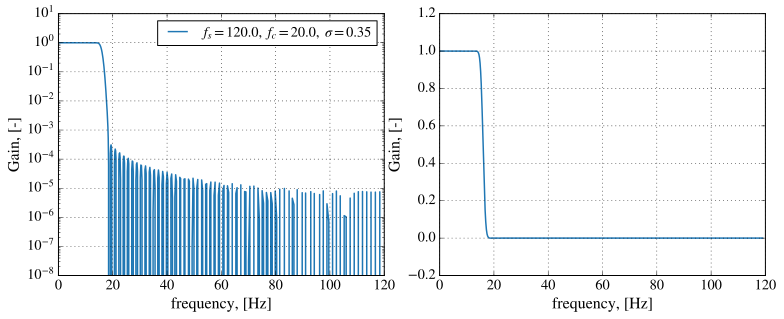

In [19]:
LP_coefs = FilterSincGaussian( consts.LP_window, consts.LP_fc, consts.LP_sigma  )
PlotFilterSpecs( LP_coefs, consts.LP_fsample, consts.LP_fc, consts.LP_sigma, 'Low_Pass_Filter' )

## Cameras filter

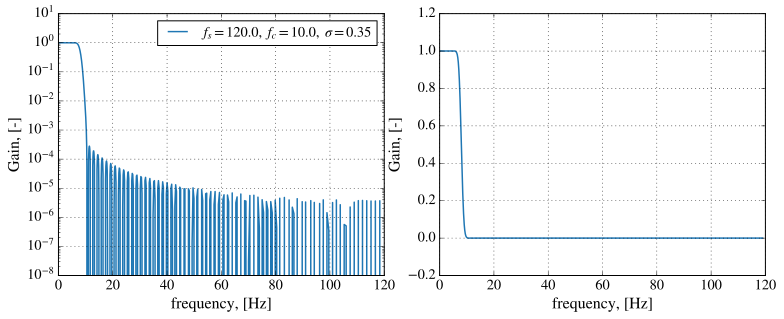

In [20]:
LP_coefs_cam = FilterSincGaussian( consts.LP_window, consts.LP_fc_cam, consts.LP_sigma  )
PlotFilterSpecs( LP_coefs_cam, consts.LP_fsample, consts.LP_fc_cam, consts.LP_sigma, 'Low_Pass_Filter_Cameras' )

In [21]:
def compute_working_time_interval( times, signal, fsample, veloc, L_beach, L_signalProbe, L_location ):

    #################################################################
    # Find signal peaks

    # Peak finder spaced at least by fs/4 sec.
    skip = fsample // 4 

    # minimum distance between extrema to be used in find_peaks
    signal_thr = np.max( ( np.max( signal ), -np.min( signal ) ) ) / 5.0

    upper_peaks_indx, _ = scipy.signal.find_peaks(  signal, height = signal_thr, distance = skip )
    lower_peaks_indx, _ = scipy.signal.find_peaks( -signal, height = signal_thr, distance = skip )

    times_upper_peaks = times[upper_peaks_indx]
    times_lower_peaks = times[lower_peaks_indx]

    signal_upper_peaks = signal[upper_peaks_indx]
    signal_lower_peaks = signal[lower_peaks_indx]

    #################################################################
    # Compute the upper/lower peaks ramp-up
    h0 = signal[upper_peaks_indx[0]]
    i0 = 0
    for i in range( 1, len( upper_peaks_indx ) ):
        if h0 >= signal[upper_peaks_indx[i]]:
            break
        else:
            h0 = signal[upper_peaks_indx[i]]
            i0 = i

    h0 = signal[lower_peaks_indx[0]]
    j0 = 0
    for j in range( 1, len( lower_peaks_indx ) ):
        if h0 <= signal[lower_peaks_indx[j]]:
            break
        else:
            h0 = signal[lower_peaks_indx[j]]
            j0 = j

    #################################################################
    # find first peak
    t0 = min( times[upper_peaks_indx[i0]], times[lower_peaks_indx[j0]] )

    #################################################################
    # The last peak 
    t1 = t0 + ( (L_beach - L_signalProbe) + (L_beach - L_location) ) / veloc

    return t0, t1

In [22]:
def compute_peaks( times, __signal, fsample, t0, t1 ):
    
    signal  = np.copy( __signal )
    signal -= np.mean( signal )

    #################################################################
    # amplitudes

    # Peak finder spaced at least by fs/4 sec.
    skip = fsample // 4 

    upper_peaks_indx, _ = scipy.signal.find_peaks(  signal, distance = skip )
    lower_peaks_indx, _ = scipy.signal.find_peaks( -signal, distance = skip )

    times_upper_peaks = times[upper_peaks_indx]
    times_lower_peaks = times[lower_peaks_indx]

    upper_peaks = __signal[upper_peaks_indx]
    lower_peaks = __signal[lower_peaks_indx]

    up_cond = np.logical_and( t0 <= times_upper_peaks, times_upper_peaks <= t1 )
    lw_cond = np.logical_and( t0 <= times_lower_peaks, times_lower_peaks <= t1 )

    # ensure that both upper and lower arrays have the same number of elements
    lup = len( np.where( up_cond == True )[0] )
    llw = len( np.where( lw_cond == True )[0] )

    if lup < llw:
        entries = np.where( lw_cond == True )[0]
        lw_cond[ entries[-1] ] =False
    if lup > llw:
        entries = np.where( up_cond == True )[0]
        up_cond[ entries[-1] ] =False

    # get the peaks
    times_upper_peaks = times_upper_peaks[ up_cond ]
    upper_peaks = upper_peaks[ up_cond ]

    times_lower_peaks = times_lower_peaks[ lw_cond ]
    lower_peaks = lower_peaks[ lw_cond ]

    return times_lower_peaks, times_upper_peaks, lower_peaks, upper_peaks

In [23]:
@dataclass
class test_data:

    def __init__( self, filename, consts ):
        # read data file of all tests
        hf = h5py.File( filename, 'r' )

        # list of the cases names
        # prefix "xp_" means experimental data 
        self.xp_cases_names = list( hf.keys() )

        # Create data structures for all the values needed
        self.xp_cameras_fn = {}
        self.xp_fsample = {}
        self.xp_freq = {}
        self.xp_D_orif = {}
        self.xp_D_OWC = {}
        self.xp_h_depth = {}
        self.xp_L_beach = {}
        self.xp_L_buoy = {}
        self.xp_L_waveProbe = {}
        self.xp_H_des = {}

        self.xp_times = {}
        self.xp_wave_h = {}
        self.xp_OWC_h = {}
        self.xp_OWC_p = {}

        self.xp_buoy_times = {}
        self.xp_buoy_surge = {}
        self.xp_buoy_heave = {}
        self.xp_buoy_sway = {}
        self.xp_buoy_roll = {}
        self.xp_buoy_yaw = {}
        self.xp_buoy_pitch = {}

        self.flt_times = {}
        self.flt_wave_h = {}
        self.flt_OWC_h = {}
        self.flt_OWC_p = {}

        self.flt_cam_times = {}
        self.flt_cam_heave = {}
        self.flt_cam_pitch = {}

        self.consts = consts

        for case_name in self.xp_cases_names:

            self.xp_cameras_fn[case_name] = hf.get( case_name + '/CamerasFileName' )[()].decode()

            fsample = hf.get( case_name + '/fsample' )[()]
            self.xp_fsample[case_name] = fsample
            self.xp_freq[case_name]    = hf.get( case_name + '/freq' )[()]
            self.xp_D_orif[case_name]  = hf.get( case_name + '/D_orifice' )[()]
            self.xp_D_OWC[case_name]   = hf.get( case_name + '/D_OWC' )[()]
            self.xp_h_depth[case_name] = hf.get( case_name + '/h_depth' )[()]
            
            self.xp_L_beach[case_name] = hf.get( case_name + '/L_beach' )[()]
            self.xp_L_buoy[case_name] = hf.get( case_name + '/L_buoy' )[()]
            self.xp_L_waveProbe[case_name]   = hf.get( case_name + '/L_waveProbe' )[()]
            self.xp_H_des[case_name]   = hf.get( case_name + '/H' )[()]
            
            xp_times   = np.array( hf.get( case_name + '/time' ) )
            xp_wave_h  = np.array( hf.get( case_name + '/WaveProbe_Ch' ) )
            xp_OWC_h   = np.array( hf.get( case_name + '/WaveProbe_Buoy' ) )
            xp_OWC_p   = np.array( hf.get( case_name + '/Delta_p' ) )

            xp_wave_h -= np.mean( xp_wave_h[0:fsample] )
            xp_OWC_h  -= np.mean( xp_OWC_h [0:fsample] )

            self.xp_times[case_name]  = xp_times
            self.xp_wave_h[case_name] = xp_wave_h
            self.xp_OWC_h[case_name]  = xp_OWC_h
            self.xp_OWC_p[case_name]  = xp_OWC_p

            flt_times, flt_wave_h = FilterSignal( LP_coefs, xp_times, xp_wave_h )
            flt_times, flt_OWC_h  = FilterSignal( LP_coefs, xp_times, xp_OWC_h )
            flt_times, flt_OWC_p  = FilterSignal( LP_coefs, xp_times, xp_OWC_p )
 
            self.flt_times[case_name]  = flt_times
            self.flt_wave_h[case_name] = flt_wave_h
            self.flt_OWC_h[case_name]  = flt_OWC_h
            self.flt_OWC_p[case_name]  = flt_OWC_p
            
        hf.close() 
    
    def process_cases( self ):

        cnt = self.consts
        twopi = 2.0 * np.pi

        n_cases = len( TD.xp_cases_names ) 

        # prefix "pp_" post-processed data
        self.pp_freq_lst = np.zeros( n_cases )       # array of frequencies
        self.pp_cp_lst = np.zeros( n_cases )         # array of phase velocity
        
        self.pp_wave_amp_lst = np.zeros( n_cases )   # array of mean wave amplitude
        self.pp_OWC_h_amp_lst = np.zeros( n_cases )  # array of OWC mean amplitude
        self.pp_OWC_p_amp_lst = np.zeros( n_cases )  # array of OWC pressure mean amplitude
        self.pp_RAO_OWC_lst = np.zeros( n_cases )    # array of OWC RAOs
        self.pp_Pwave_lst = np.zeros( n_cases )      # array of wave power
        self.pp_Pturb_lst = np.zeros( n_cases )      # array of turbine power
        self.pp_CWR_lst = np.zeros( n_cases )        # array of CWR
        self.pp_cp_lst = np.zeros( n_cases )         # array of phase velocity
        self.pp_cg_lst = np.zeros( n_cases )         # array of group velicity
        self.pp_λ_lst = np.zeros( n_cases )          # array of wavelength
        self.pp_λh_lst = np.zeros( n_cases )         # array of wavelength/depth
        self.pp_kh_lst = np.zeros( n_cases )         # array of k*h
        # self.pp_Pwave_des_lst = np.zeros( n_cases )  # array of desired wave power 
        self.pp_t0_lst = np.zeros( n_cases )         # working time interval
        self.pp_t1_lst = np.zeros( n_cases )         # [t0,t1]

        for num, case_key in enumerate( TD.xp_cases_names ):

            print( case_key )

            #========================================================================
            # variables of this test cases
            fsample = self.xp_fsample[ case_key ]   # sampling frequency
            freq = self.xp_freq[ case_key ]         # Wave Frequency
            D_OWC = self.xp_D_OWC[ case_key ]
            h_depth = self.xp_h_depth[ case_key ]
            L_beach = self.xp_L_beach[ case_key ]
            L_buoy = self.xp_L_buoy[ case_key ]
            L_waveProbe = self.xp_L_waveProbe[ case_key ]

            times = self.flt_times[ case_key ]

            wave_h = self.flt_wave_h[ case_key ]

            OWC_h = self.flt_OWC_h[ case_key ]
            OWC_p = self.flt_OWC_p[ case_key ]
            
            Do = self.xp_D_orif[ case_key ]
            H_des = self.xp_H_des[ case_key ] / 2.0

            #========================================================================
            # Wave characteristics
            ω  = twopi * freq                       # Angular Frequency
            kh = dispersion_relation( ω, h_depth )  # Wave Number for infinite depth water conditions
            k  = kh / h_depth                       # Wave Number
            cp = ω / k                              # Wave crest Speed or phase Velocity
            λ  = twopi / k                          # Wave Length
            λh  = twopi / kh                        # Wave Length/ Depth
            Tw = 1.0 / freq                         # wave period

            #========================================================================
            # time interval used for mean values
            # First estimate
            t0, t1 = compute_working_time_interval( times, wave_h, fsample, cp, L_beach, L_waveProbe, L_buoy )

            #========================================================================
            # Compute means
            waves_times_lower_peaks, waves_times_upper_peaks, \
                waves_lower_peaks, waves_upper_peaks = compute_peaks( times, wave_h, fsample, t0, t1 )
            wave_amp = 0.5 * ( np.mean( waves_upper_peaks ) - np.mean( waves_lower_peaks ) )

            cg = group_velocity( h_depth, 2.0*wave_amp, freq ) 
            t0, t1 = compute_working_time_interval( times, wave_h, fsample, cg, L_beach, L_waveProbe, L_buoy )

            #========================================================================
            # wave power [W]
            Pwave = wave_power( cnt, h_depth, 2.0*wave_amp, freq )
            Pwave *= D_OWC

            # desired wave power [W]
            # Pwave_des = wave_power( cnt, h_depth, H_des, freq ) 
            # Pwave_des *= D_OWC
            
            #========================================================================
            # Compute the OWC motion amplitute
            OWC_h_times_lower_peaks, OWC_h_times_upper_peaks, \
                OWC_h_lower_peaks, OWC_h_upper_peaks = compute_peaks( times, OWC_h, fsample, t0, t1 )
            OWC_h_amp = 0.5 * ( np.mean( OWC_h_upper_peaks ) - np.mean( OWC_h_lower_peaks ) )

            #========================================================================
            # Compute the OWC motion amplitute
            # Peak finder spaced at least by fs/4 sec.
            OWC_p_times_lower_peaks, OWC_p_times_upper_peaks, \
                OWC_p_lower_peaks, OWC_p_upper_peaks = compute_peaks( times, OWC_p, fsample, t0, t1 )
            OWC_p_amp = 0.5 * ( np.mean( OWC_p_upper_peaks ) - np.mean( OWC_p_lower_peaks ) )
            
            # ========================================
            # Compute turbine power
            tt0 = np.min( ( OWC_p_times_lower_peaks[ 0], OWC_p_times_upper_peaks[ 0] ) )
            tt1 = np.min( ( OWC_p_times_lower_peaks[-1], OWC_p_times_upper_peaks[-1] ) )

            t_cond = np.logical_and( tt0 <= times, times <= tt1 )
            ttimes = times[ t_cond ]
            tOWC_p = OWC_p[ t_cond ]
            
            Ao = np.pi * Do**2 / 4.0
            Cd = 0.65
            Co = np.sqrt( 2.0 ) * Ao * Cd 
            Q_turb = np.sign( tOWC_p ) * Co * np.sqrt( np.abs( tOWC_p ) / cnt.𝜌_air )
            P_turb = tOWC_p * Q_turb
            Pturb = np.mean( P_turb )

            #========================================================================
            self.pp_freq_lst[num] = np.round( freq, 2 )
            self.pp_cp_lst[num] = np.round( cp, 2 )

            self.pp_t0_lst[num] = np.round( t0, 2 )
            self.pp_t1_lst[num] = np.round( t1, 2 )

            self.pp_wave_amp_lst[num]  = np.round( wave_amp, 4 )
            self.pp_OWC_h_amp_lst[num] = np.round( OWC_h_amp, 4 )
            self.pp_OWC_p_amp_lst[num] = np.round( OWC_p_amp, 2 )
            self.pp_RAO_OWC_lst[num] = np.round( OWC_h_amp / wave_amp, 4 )
            self.pp_Pwave_lst[num] = np.round( Pwave, 4 )
            self.pp_Pturb_lst[num] = np.round( Pturb, 4 )
            self.pp_CWR_lst[num] = np.round( Pturb / Pwave, 3 )
            self.pp_cp_lst[num] = np.round( cp, 3 )
            self.pp_cg_lst[num] = np.round( cg, 3 )

            self.pp_λ_lst[num] = np.round( λ, 2 )
            self.pp_λh_lst[num] = np.round( λh, 2 )
            self.pp_kh_lst[num] = np.round( kh, 4 )
            # self.pp_Pwave_des_lst[num] = np.round( Pwave_des, 4 )
        
    def process_camera_cases( self ):

        n_cases = len( TD.xp_cases_names ) 

        self.pp_RAO_heave_lst = np.zeros( n_cases )    # array of heave RAOs
        self.pp_RAO_pitch_lst = np.zeros( n_cases )    # array of pitch RAOs
        self.pp_t0_cam_lst = np.zeros( n_cases )       # working time interval
        self.pp_t1_cam_lst = np.zeros( n_cases )       # [t0,t1]

        for num, case_key in enumerate( TD.xp_cases_names ):

            cameras_fn = TD.xp_cameras_fn[ case_key ].replace( '.csv', '.xlsx' )

            print( cameras_fn )

            df = pd.read_excel( cameras_fn )

            fsample = TD.xp_fsample[ case_key ]

            TD.xp_buoy_times[ case_key ] = np.array( df['time'] )
            TD.xp_buoy_roll [ case_key ] = np.array( df['roll'] )
            TD.xp_buoy_yaw  [ case_key ] = np.array( df['yaw'] )
            TD.xp_buoy_pitch[ case_key ] = np.array( df['pitch'] )
            TD.xp_buoy_surge[ case_key ] = np.array( df['surge'] )
            TD.xp_buoy_heave[ case_key ] = np.array( df['heave'] )
            TD.xp_buoy_sway [ case_key ] = np.array( df['sway'] )

            TD.xp_buoy_roll [ case_key ] -= np.nanmean( TD.xp_buoy_roll [ case_key ][0:fsample] )
            TD.xp_buoy_yaw  [ case_key ] -= np.nanmean( TD.xp_buoy_yaw  [ case_key ][0:fsample] )
            TD.xp_buoy_pitch[ case_key ] -= np.nanmean( TD.xp_buoy_pitch[ case_key ][0:fsample] )

            TD.xp_buoy_surge[ case_key ] -= np.nanmean( TD.xp_buoy_surge[ case_key ][0:fsample] )
            TD.xp_buoy_heave[ case_key ] -= np.nanmean( TD.xp_buoy_heave[ case_key ][0:fsample] )
            TD.xp_buoy_sway [ case_key ] -= np.nanmean( TD.xp_buoy_sway [ case_key ][0:fsample] )
                    
            fsample = TD.xp_fsample[ case_key ]   # sampling frequency
            freq    = TD.xp_freq[ case_key ]         # Wave Frequency
            L_beach = TD.xp_L_beach[case_key] 
            L_buoy  = TD.xp_L_buoy[case_key] 

            wave_amp = TD.pp_wave_amp_lst[num]
            cg       = TD.pp_cg_lst[num]

            skip    = fsample // 10

            times = TD.xp_buoy_times[ case_key ]
            heave = TD.xp_buoy_heave[ case_key ]
            pitch = TD.xp_buoy_pitch[ case_key ]

            flt_times, flt_heave = FilterSignal( LP_coefs_cam, times, heave )
            flt_times, flt_pitch = FilterSignal( LP_coefs_cam, times, pitch )

            mean_heave = np.mean( flt_heave[0:fsample] )
            flt_heave -= mean_heave

            t0, t1 = compute_working_time_interval( flt_times, flt_heave, fsample, cg, L_beach, L_buoy, L_buoy )

            i0 = index_nearest( times, t0 )
            i1 = index_nearest( times, t1 )

            #========================================================================
            clipped_heave = flt_heave[0:i1]

            mean_heave = np.mean( flt_heave[i0:i1] )
            clipped_heave -= mean_heave
            heave -= mean_heave
            flt_heave -= mean_heave

            # heave_thr = np.max( ( np.max( clipped_heave ), -np.min( clipped_heave ) ) ) / 20.0
            heave_upper_peaks_indx, _ = scipy.signal.find_peaks(  clipped_heave, distance = skip )
            heave_lower_peaks_indx, _ = scipy.signal.find_peaks( -clipped_heave, distance = skip )

            heave_times_lower_peaks, heave_times_upper_peaks, \
                heave_lower_peaks, heave_upper_peaks = compute_peaks( times, clipped_heave, fsample, t0, t1 )
            heave_amp = 0.5 * ( np.mean( heave_upper_peaks ) - np.mean( heave_lower_peaks ) )

            self.pp_RAO_heave_lst[num] = np.round( heave_amp / wave_amp, 4 )

            #========================================================================
            clipped_pitch = flt_pitch[0:i1]

            mean_pitch = np.mean( flt_pitch[i0:i1] )

            clipped_pitch -= mean_pitch
            pitch -= mean_pitch
            flt_pitch -= mean_pitch

            # pitch_thr = np.max( ( np.max( clipped_pitch ), -np.min( clipped_pitch ) ) ) / 60.0
            pitch_upper_peaks_indx, _ = scipy.signal.find_peaks(  clipped_pitch, distance = skip )
            pitch_lower_peaks_indx, _ = scipy.signal.find_peaks( -clipped_pitch, distance = skip )

            pitch_times_lower_peaks, pitch_times_upper_peaks, \
                pitch_lower_peaks, pitch_upper_peaks = compute_peaks( times, clipped_pitch, fsample, t0, t1 )
            pitch_amp = 0.5 * ( np.mean( pitch_upper_peaks ) - np.mean( pitch_lower_peaks ) )

            self.pp_t0_cam_lst[num] = np.round( t0, 2 )
            self.pp_t1_cam_lst[num] = np.round( t1, 2 )

            self.pp_RAO_pitch_lst[num] = np.round( pitch_amp / wave_amp, 4 )

            #========================================================================
            self.flt_cam_times[case_key] = flt_times
            self.flt_cam_heave[case_key] = flt_heave
            self.flt_cam_pitch[case_key] = flt_pitch


In [24]:
tests_filename = "%s_Tests_V6" % CASE_prefix

TD = test_data( tests_filename + '.h5', consts )
TD.process_cases()

KB4m_H0.04m_f0.64Hz
KB4m_H0.04m_f0.70Hz
KB4m_H0.04m_f0.74Hz
KB4m_H0.04m_f0.78Hz
KB4m_H0.04m_f0.82Hz
KB4m_H0.04m_f0.86Hz
KB4m_H0.04m_f0.90Hz
KB4m_H0.04m_f0.94Hz
KB4m_H0.04m_f1.00Hz
KB4m_H0.04m_f1.02Hz
KB4m_H0.04m_f1.04Hz
KB4m_H0.04m_f1.06Hz
KB4m_H0.04m_f1.08Hz
KB4m_H0.04m_f1.10Hz
KB4m_H0.04m_f1.12Hz
KB4m_H0.04m_f1.14Hz
KB4m_H0.04m_f1.16Hz
KB4m_H0.04m_f1.18Hz
KB4m_H0.04m_f1.22Hz
KB4m_H0.04m_f1.28Hz
KB4m_H0.04m_f1.34Hz
KB4m_H0.04m_f1.42Hz
KB4m_H0.04m_f1.50Hz


In [25]:
TD.process_camera_cases()

KB4m_H0.04m_f0.64Hz.xlsx
KB4m_H0.04m_f0.70Hz.xlsx
KB4m_H0.04m_f0.74Hz.xlsx
KB4m_H0.04m_f0.78Hz.xlsx
KB4m_H0.04m_f0.82Hz.xlsx
KB4m_H0.04m_f0.86Hz.xlsx
KB4m_H0.04m_f0.90Hz.xlsx
KB4m_H0.04m_f0.94Hz.xlsx
KB4m_H0.04m_f1.00Hz.xlsx
KB4m_H0.04m_f1.02Hz.xlsx
KB4m_H0.04m_f1.04Hz.xlsx
KB4m_H0.04m_f1.06Hz.xlsx
KB4m_H0.04m_f1.08Hz.xlsx
KB4m_H0.04m_f1.10Hz.xlsx
KB4m_H0.04m_f1.12Hz.xlsx
KB4m_H0.04m_f1.14Hz.xlsx
KB4m_H0.04m_f1.16Hz.xlsx
KB4m_H0.04m_f1.18Hz.xlsx
KB4m_H0.04m_f1.22Hz.xlsx
KB4m_H0.04m_f1.28Hz.xlsx
KB4m_H0.04m_f1.34Hz.xlsx
KB4m_H0.04m_f1.42Hz.xlsx
KB4m_H0.04m_f1.50Hz.xlsx


In [26]:
data =  {   "Freq [Hz]": TD.pp_freq_lst, 
            "kh [-]" : TD.pp_kh_lst, 
            "λ [m]" : TD.pp_λ_lst,
            "λ/h [m]" : TD.pp_λh_lst,
            "crest speed [m/s]" : TD.pp_cp_lst,
            "group speed [m/s]" : TD.pp_cg_lst,         
            "wave amp [m]": TD.pp_wave_amp_lst, 
            "OWC amp [m]": TD.pp_OWC_h_amp_lst, 
            "Δp amp [Pa]": TD.pp_OWC_p_amp_lst, 
            "Pwave × D_OWC [W]": TD.pp_Pwave_lst, 
            "Pturb [W]": TD.pp_Pturb_lst,
            "CWR [-]": TD.pp_CWR_lst,
            "RAO_OWC": TD.pp_RAO_OWC_lst, 
            "RAO_heave": TD.pp_RAO_heave_lst, 
            "RAO_pitch": TD.pp_RAO_pitch_lst, 
            "t0 [s]": TD.pp_t0_lst, 
            "t1 [s]": TD.pp_t1_lst,
            "t0_cam [s]": TD.pp_t0_cam_lst, 
            "t1_cam [s]": TD.pp_t1_cam_lst
        }

# Create Excel File
XLS_filename = tests_filename + '.xlsx'
print( XLS_filename )

writer = pd.ExcelWriter( XLS_filename, engine='xlsxwriter' )

workbook  = writer.book
right = workbook.add_format( {'align': 'right'} )
header_format = workbook.add_format( { 'fg_color': '#FFFF00', 'border': 1,
                                    'align' : 'center' } )

for case_key in TD.xp_cases_names:
    freq = TD.xp_freq[ case_key ]         # Wave Frequency

    flt_times = TD.flt_times[ case_key ]

    flt_wave_h = TD.flt_wave_h[ case_key ]
    flt_OWC_h = TD.flt_OWC_h[ case_key ]
    flt_OWC_p = TD.flt_OWC_p[ case_key ]

    flt_cam_times = TD.flt_cam_times[ case_key ]
    flt_cam_heave = TD.flt_cam_heave[ case_key ]
    flt_cam_pitch = TD.flt_cam_pitch[ case_key ]

    ml = np.min( (len(flt_times), len(flt_cam_times) ) )
    
    data_freq = { "times": flt_times[0:ml], 
            "flt_wave_h": flt_wave_h[0:ml],
            "flt_OWC_h": flt_OWC_h[0:ml],
            "flt_OWC_p": flt_OWC_p[0:ml],
            "flt_cam_times": flt_cam_times[0:ml],
            "flt_cam_heave": flt_cam_heave[0:ml],
            "flt_cam_pitch": flt_cam_pitch[0:ml]
    }    

    df_freq = pd.DataFrame( data_freq )
    df_freq.to_excel( writer, index=False, sheet_name='f%.2fHz' % freq )

df = pd.DataFrame( data )
df.to_excel( writer, index=False, sheet_name='Summary' )

worksheet = writer.sheets['Summary']
worksheet.set_column( 'A:P', 14, right )

# Write the column headers with the defined format
for col_num, value in enumerate(df.columns.values):
    worksheet.write( 0, col_num, value, header_format )
worksheet.freeze_panes(1, 1)
writer.save()

df

KB4m_Tests_V6.xlsx


,Freq [Hz],kh [-],λ [m],λ/h [m],crest speed [m/s],group speed [m/s],wave amp [m],OWC amp [m],Δp amp [Pa],Pwave × D_OWC [W],Pturb [W],CWR [-],RAO_OWC,RAO_heave,RAO_pitch,t0 [s],t1 [s],t0_cam [s],t1_cam [s]
0,0.64,1.0365,2.96,6.06,1.893,1.448,0.0092,0.0086,1.55,0.0957,0.0001,0.001,0.9320,1.2550,140.9131,9.12,22.37,10.67,23.48
1,0.70,1.1689,2.62,5.38,1.836,1.336,0.0106,0.0151,8.21,0.1182,0.0003,0.002,1.4175,1.2102,135.7227,15.14,29.49,16.72,30.61
2,0.74,1.2632,2.43,4.97,1.796,1.263,0.0108,0.0193,27.02,0.1144,0.0007,0.006,1.7946,1.2902,137.2532,15.49,30.68,17.11,31.80
3,0.78,1.3629,2.25,4.61,1.755,1.192,0.0112,0.0220,40.22,0.1168,0.0012,0.010,1.9666,1.3659,200.7199,15.90,31.99,18.12,33.70
4,0.82,1.4684,2.09,4.28,1.712,1.124,0.0121,0.0244,71.07,0.1293,0.0017,0.013,2.0096,1.4571,161.0508,16.10,33.17,18.91,35.42
5,0.86,1.5804,1.94,3.98,1.669,1.058,0.0112,0.0239,74.44,0.1031,0.0018,0.018,2.1412,1.5762,122.1340,13.89,32.02,14.34,31.88
6,0.90,1.6994,1.80,3.70,1.624,0.997,0.0111,0.0242,91.97,0.0955,0.0022,0.023,2.1870,1.7144,126.8072,13.82,33.07,16.08,34.69
7,0.94,1.8260,1.68,3.44,1.578,0.939,0.0107,0.0251,108.76,0.0849,0.0029,0.034,2.3393,1.9858,123.3724,14.66,35.09,17.40,37.17
8,1.00,2.0310,1.51,3.09,1.510,0.860,0.0102,0.0294,163.91,0.0706,0.0054,0.077,2.8753,2.8089,125.9423,15.52,37.82,18.24,39.82
9,1.02,2.1035,1.46,2.99,1.487,0.837,0.0095,0.0306,178.42,0.0586,0.0062,0.106,3.2306,3.2643,167.2484,15.12,38.04,18.85,41.02


## Case numbers

In [27]:
for n, case_name in enumerate( TD.xp_cases_names ):
    print( '%2i  =>  %s' % ( n, case_name ) )

 0  =>  KB4m_H0.04m_f0.64Hz
 1  =>  KB4m_H0.04m_f0.70Hz
 2  =>  KB4m_H0.04m_f0.74Hz
 3  =>  KB4m_H0.04m_f0.78Hz
 4  =>  KB4m_H0.04m_f0.82Hz
 5  =>  KB4m_H0.04m_f0.86Hz
 6  =>  KB4m_H0.04m_f0.90Hz
 7  =>  KB4m_H0.04m_f0.94Hz
 8  =>  KB4m_H0.04m_f1.00Hz
 9  =>  KB4m_H0.04m_f1.02Hz
10  =>  KB4m_H0.04m_f1.04Hz
11  =>  KB4m_H0.04m_f1.06Hz
12  =>  KB4m_H0.04m_f1.08Hz
13  =>  KB4m_H0.04m_f1.10Hz
14  =>  KB4m_H0.04m_f1.12Hz
15  =>  KB4m_H0.04m_f1.14Hz
16  =>  KB4m_H0.04m_f1.16Hz
17  =>  KB4m_H0.04m_f1.18Hz
18  =>  KB4m_H0.04m_f1.22Hz
19  =>  KB4m_H0.04m_f1.28Hz
20  =>  KB4m_H0.04m_f1.34Hz
21  =>  KB4m_H0.04m_f1.42Hz
22  =>  KB4m_H0.04m_f1.50Hz


## Collect data for plotting case number

case_num selects the frequency number

In [28]:
case_num = 10
case_key = TD.xp_cases_names[ case_num ]

fsample = TD.xp_fsample[ case_key ]   # sampling frequency
freq    = TD.xp_freq[ case_key ]         # Wave Frequency
H       = 2*TD.pp_wave_amp_lst[case_num]

xp_times  = TD.xp_times[ case_key ]
xp_wave_h = TD.xp_wave_h[ case_key ]
xp_OWC_h  = TD.xp_OWC_h[ case_key ]
xp_OWC_p  = TD.xp_OWC_p[ case_key ]

times   = TD.flt_times[ case_key ]
wave_h  = TD.flt_wave_h[ case_key ]
OWC_h   = TD.flt_OWC_h[ case_key ]
OWC_p   = TD.flt_OWC_p[ case_key ]

t0 = TD.pp_t0_lst[ case_num ]
t1 = TD.pp_t1_lst[ case_num ]

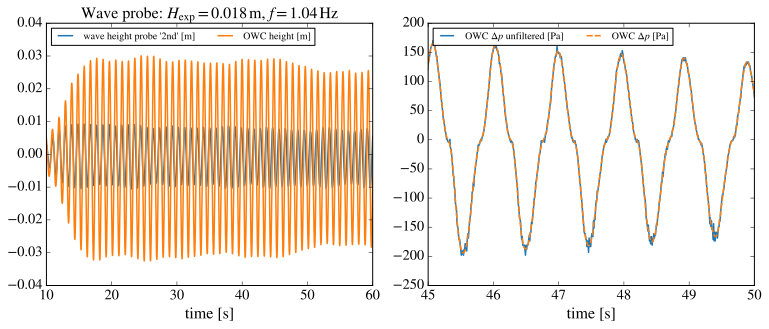

In [29]:
fig, (ax1, ax2) = mpl.subplots(1,2, figsize=(12, 4.5) )
fig.subplots_adjust( wspace = 0.17 )

ax1.plot( times, wave_h, '-', label="wave height probe '2nd' [m]" )
ax1.plot( times, OWC_h, '-', label='OWC height [m]' )
ax1.set_xlim( 10, 60 )
ax1.legend( loc='upper left', fontsize=10, ncols=2 )
ax1.set_xlabel( 'time [s]')

ax2.plot( xp_times, xp_OWC_p, label='OWC $\Delta p$ unfiltered [Pa]' )
ax2.plot( times, OWC_p, label='OWC $\Delta p$ [Pa]' )
ax2.set_xlim( 45, 50 )
# ax2.set_ylim( 400, 1100 )
ax2.legend( loc='upper left', fontsize=10, ncols=2 )
ax2.set_xlabel( 'time [s]')
ax1.set_title( "Wave probe: " + "$H_\mathrm{exp} = %1.3f\,$m" % H + ", " + "$f = %1.2f\,$Hz" % freq )

fig_filename = tests_filename + '_WavePressure_TimeSeries'

# for pdflatex
mpl.savefig( fig_filename + '.pdf', bbox_inches='tight', pad_inches=0.02 )

# for MS WORD
mpl.savefig( fig_filename + '.jpg', bbox_inches='tight', pad_inches=0.02 )
mpl.savefig( fig_filename + '.svg', bbox_inches='tight', pad_inches=0.02 );

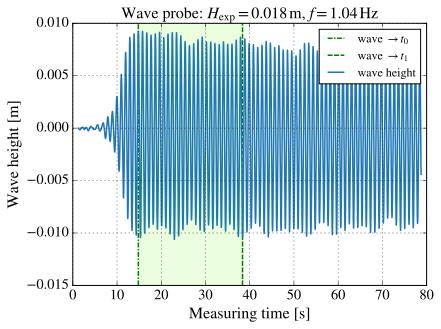

In [30]:
mpl.axvspan( t0, t1, color='#e5ffd5c2')
mpl.axvline( t0, dashes=(5,1.5,1.5,1.5), color='g', label=r'wave $\rightarrow t_0$' )
mpl.axvline( t1, dashes=(5,1.5), color='g', label=r'wave $\rightarrow t_1$' )

mpl.plot( times, wave_h, label='wave height' )

mpl.grid()
mpl.legend(loc='upper right', fontsize=12)
mpl.xlabel( "Measuring time [s]" )
mpl.ylabel( "Wave height [m]" )
mpl.title( "Wave probe: " + "$H_\mathrm{exp} = %1.3f\,$m" % H + ", " + "$f = %1.2f\,$Hz" % freq )

fig_filename = tests_filename + '_Wave_TimeSeries'

# for pdflatex
mpl.savefig( fig_filename + '.pdf', bbox_inches='tight', pad_inches=0.02 )

# for MS WORD
mpl.savefig( fig_filename + '.jpg', bbox_inches='tight', pad_inches=0.02 )
mpl.savefig( fig_filename + '.svg', bbox_inches='tight', pad_inches=0.02 );

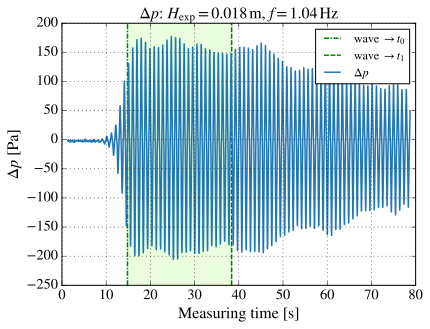

In [31]:
mpl.axvspan( t0, t1, color='#e5ffd5c2')
mpl.axvline( t0, dashes=(5,1.5,1.5,1.5), color='g', label=r'wave $\rightarrow t_0$' )
mpl.axvline( t1, dashes=(5,1.5), color='g', label=r'wave $\rightarrow t_1$' )

mpl.plot( times, OWC_p, label='$\Delta p$' )
mpl.grid()
mpl.legend(loc='upper right', fontsize=12)
mpl.xlabel( "Measuring time [s]" )
mpl.ylabel( "$\Delta p$ [Pa]" )
mpl.title( "$\Delta p$: " + "$H_\mathrm{exp} = %1.3f\,$m" % H + ", " + "$f = %1.2f\,$Hz" % freq )

fig_filename = tests_filename + '_Pressure_TimeSeries'

# for pdflatex
mpl.savefig( fig_filename + '.pdf', bbox_inches='tight', pad_inches=0.02 )

# for MS WORD
mpl.savefig( fig_filename + '.jpg', bbox_inches='tight', pad_inches=0.02 )
mpl.savefig( fig_filename + '.svg', bbox_inches='tight', pad_inches=0.02 );

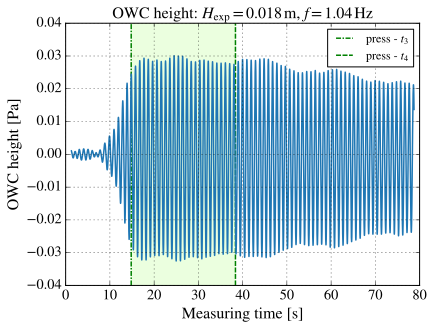

In [32]:
mpl.axvspan( t0, t1, color='#e5ffd5c2')
mpl.axvline( t0, dashes=(5,1.5,1.5,1.5), color='g', label='press - $t_3$' )
mpl.axvline( t1, dashes=(5,1.5), color='g', label='press - $t_4$' )

mpl.plot( times, OWC_h )
mpl.grid()
mpl.legend(loc='upper right', fontsize=12)
mpl.xlabel( "Measuring time [s]" )
mpl.ylabel( "OWC height [Pa]" )
mpl.title( "OWC height: " + "$H_\mathrm{exp} = %1.3f\,$m" % H + ", " + "$f = %1.2f\,$Hz" % freq )

fig_filename = tests_filename + '_OWC_TimeSeries'

# for pdflatex
mpl.savefig( fig_filename + '.pdf', bbox_inches='tight', pad_inches=0.02 )

# for MS WORD
mpl.savefig( fig_filename + '.jpg', bbox_inches='tight', pad_inches=0.02 )
mpl.savefig( fig_filename + '.svg', bbox_inches='tight', pad_inches=0.02 );

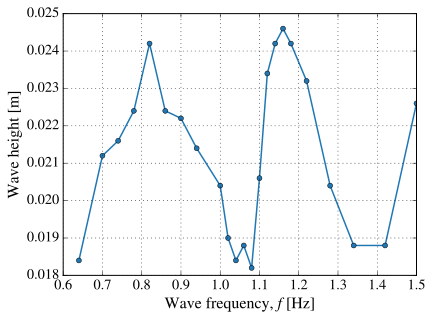

In [33]:
mpl.plot( TD.pp_freq_lst, 2*TD.pp_wave_amp_lst, 'o-' )
mpl.xlabel( r"Wave frequency, $f$ [Hz]" )
mpl.ylabel( r"Wave height [m]")
mpl.grid()

fig_filename = tests_filename + '_WaveHeight'

# for pdflatex
mpl.savefig( fig_filename + '.pdf', bbox_inches='tight', pad_inches=0.02 )

# for MS WORD
mpl.savefig( fig_filename + '.jpg', bbox_inches='tight', pad_inches=0.02 )
mpl.savefig( fig_filename + '.svg', bbox_inches='tight', pad_inches=0.02 );

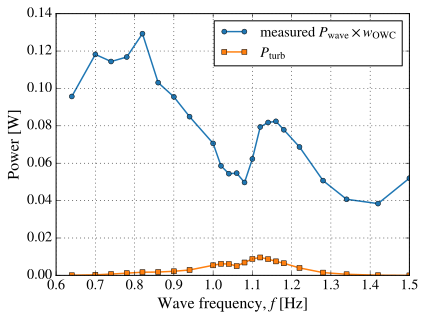

In [34]:
mpl.plot( TD.pp_freq_lst, TD.pp_Pwave_lst, 'o-', label=r'measured $P_\mathrm{wave}\times w_\mathrm{OWC}$'  )
mpl.plot( TD.pp_freq_lst, TD.pp_Pturb_lst, 's-', label = r'$P_\mathrm{turb}$' )
mpl.xlabel( r"Wave frequency, $f$ [Hz]" )
mpl.ylabel( r"Power [W]")
mpl.legend()
mpl.grid()

fig_filename = tests_filename + '_WaveTurbPowers'

# for pdflatex
mpl.savefig( fig_filename + '.pdf', bbox_inches='tight', pad_inches=0.02 )

# for MS WORD
mpl.savefig( fig_filename + '.jpg', bbox_inches='tight', pad_inches=0.02 )
mpl.savefig( fig_filename + '.svg', bbox_inches='tight', pad_inches=0.02 )

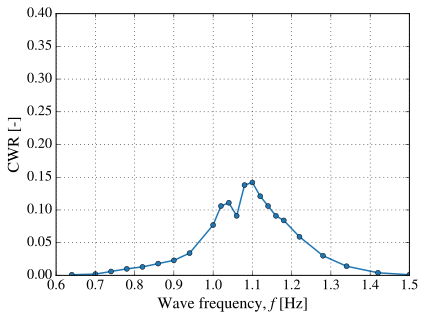

In [35]:
mpl.plot( TD.pp_freq_lst, TD.pp_CWR_lst, 'o-' )
mpl.xlabel( "Wave frequency, $f$ [Hz]" )
mpl.ylabel( "CWR [-]")
mpl.grid()
mpl.ylim( 0, 0.4 )

fig_filename = tests_filename + '_CWR'

# for pdflatex
mpl.savefig( fig_filename + '.pdf', bbox_inches='tight', pad_inches=0.02 )

# for MS WORD
mpl.savefig( fig_filename + '.jpg', bbox_inches='tight', pad_inches=0.02 )
mpl.savefig( fig_filename + '.svg', bbox_inches='tight', pad_inches=0.02 )

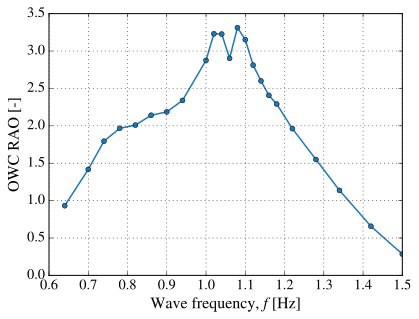

In [36]:
mpl.plot( TD.pp_freq_lst, TD.pp_RAO_OWC_lst, 'o-' )
mpl.xlabel( "Wave frequency, $f$ [Hz]" )
mpl.ylabel( "OWC RAO [-]")
mpl.grid()

fig_filename = tests_filename + '_RAO_OWC'

# for pdflatex
mpl.savefig( fig_filename + '.pdf', bbox_inches='tight', pad_inches=0.02 )

# for MS WORD
mpl.savefig( fig_filename + '.jpg', bbox_inches='tight', pad_inches=0.02 )
mpl.savefig( fig_filename + '.svg', bbox_inches='tight', pad_inches=0.02 )

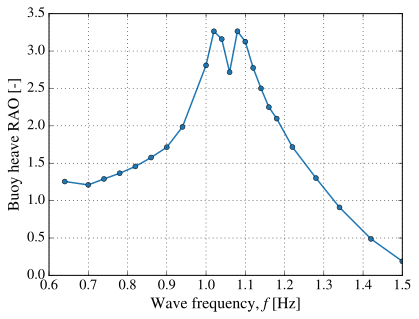

In [37]:
mpl.plot( TD.pp_freq_lst, TD.pp_RAO_heave_lst, 'o-' )
mpl.xlabel( "Wave frequency, $f$ [Hz]" )
mpl.ylabel( "Buoy heave RAO [-]")
mpl.grid()

fig_filename = tests_filename + '_RAO_heave'

# for pdflatex
mpl.savefig( fig_filename + '.pdf', bbox_inches='tight', pad_inches=0.02 )

# for MS WORD
mpl.savefig( fig_filename + '.jpg', bbox_inches='tight', pad_inches=0.02 )
mpl.savefig( fig_filename + '.svg', bbox_inches='tight', pad_inches=0.02 )

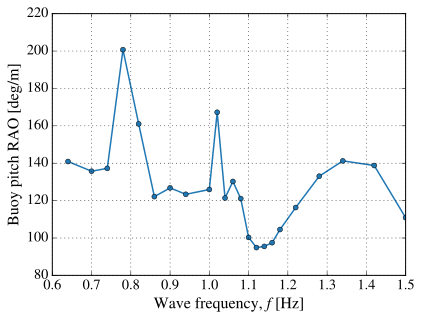

In [38]:
mpl.plot( TD.pp_freq_lst, TD.pp_RAO_pitch_lst, 'o-' )
mpl.xlabel( "Wave frequency, $f$ [Hz]" )
mpl.ylabel( "Buoy pitch RAO [deg/m]")
mpl.grid()

fig_filename = tests_filename + '_RAO_pitch'

# for pdflatex
mpl.savefig( fig_filename + '.pdf', bbox_inches='tight', pad_inches=0.02 )

# for MS WORD
mpl.savefig( fig_filename + '.jpg', bbox_inches='tight', pad_inches=0.02 )
mpl.savefig( fig_filename + '.svg', bbox_inches='tight', pad_inches=0.02 )

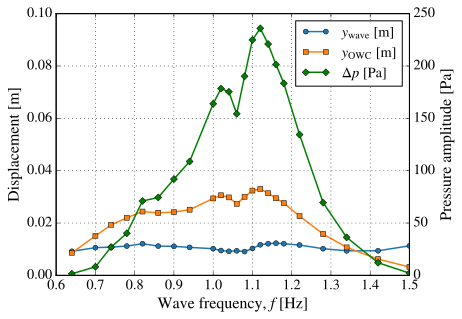

In [39]:
mpl.plot( TD.pp_freq_lst, TD.pp_wave_amp_lst, 'o-', label = r'$y_\mathrm{wave}$ [m]' )
mpl.plot( TD.pp_freq_lst, TD.pp_OWC_h_amp_lst, 's-', label = r'$y_\mathrm{OWC}$ [m]' )
mpl.plot( [np.nan], [np.nan],  'Dg-', label='$\Delta p$ [Pa]' )
mpl.xlabel( "Wave frequency, $f$ [Hz]" )
mpl.ylabel( "Displacement [m]")
mpl.grid()
mpl.legend()
mpl.ylim( 0, 0.10 )

ax2 = mpl.gca().twinx()
ax2.plot( TD.pp_freq_lst, TD.pp_OWC_p_amp_lst, 'Dg-' )
ax2.set_ylabel( "Pressure amplitude [Pa]")

fig_filename = tests_filename + '_Displacments_Pressure'

# for pdflatex
mpl.savefig( fig_filename + '.pdf', bbox_inches='tight', pad_inches=0.02 )

# for MS WORD
mpl.savefig( fig_filename + '.jpg', bbox_inches='tight', pad_inches=0.02 )
mpl.savefig( fig_filename + '.svg', bbox_inches='tight', pad_inches=0.02 )

In [40]:
# Create a zip file for download with all the results

In [41]:
!zip {'RESULTS_'+tests_filename+'.zip'} \
      {tests_filename+'*.xlsx'} \
      {tests_filename+'*.jpg'} \
      {tests_filename+'*.pdf'} \
      {tests_filename+'*.svg'} \
      {'Low_Pass_Filter*.*'}

  adding: KB4m_Tests_V6.xlsx (deflated 0%)
  adding: KB4m_Tests_V6_CWR.jpg (deflated 14%)
  adding: KB4m_Tests_V6_Displacments_Pressure.jpg (deflated 11%)
  adding: KB4m_Tests_V6_OWC_TimeSeries.jpg (deflated 8%)
  adding: KB4m_Tests_V6_Pressure_TimeSeries.jpg (deflated 8%)
  adding: KB4m_Tests_V6_RAO_heave.jpg (deflated 17%)
  adding: KB4m_Tests_V6_RAO_OWC.jpg (deflated 17%)
  adding: KB4m_Tests_V6_RAO_pitch.jpg (deflated 16%)
  adding: KB4m_Tests_V6_WaveHeight.jpg (deflated 14%)
  adding: KB4m_Tests_V6_WavePressure_TimeSeries.jpg (deflated 13%)
  adding: KB4m_Tests_V6_Wave_TimeSeries.jpg (deflated 8%)
  adding: KB4m_Tests_V6_WaveTurbPowers.jpg (deflated 16%)
  adding: KB4m_Tests_V6_CWR.pdf (deflated 33%)
  adding: KB4m_Tests_V6_Displacments_Pressure.pdf (deflated 30%)
  adding: KB4m_Tests_V6_OWC_TimeSeries.pdf (deflated 21%)
  adding: KB4m_Tests_V6_Pressure_TimeSeries.pdf (deflated 19%)
  adding: KB4m_Tests_V6_RAO_heave.pdf (deflated 32%)
  adding: KB4m_Tests_V6_RAO_OWC.pdf (deflated 